# ROMS pre/post-processing code using PYROMS
## Requirements
#### Module
This demo requires **pyROMS2** to be properly installed, preferably with Conda. Additionally it requires the **cmocean** package to generate colormaps. **cmocean** can be easily installed with conda

```bash
$ conda install -c conda-forge cmocean
```

For the grid utilities, the backend **qt** is used to force a new window when the utility GUI is launched. This is because the matplotlib inline widget does not handle mouse move (drag) events very well, at least in my few tests. The plotting backend is swithed with the magic command

**%matplotlib qt**

#### Data
[**BedMachine Antarctica v2**](https://sites.ps.uci.edu/morlighem/dataproducts/bedmachine-antarctica/) is used to provide bathymetry and ice sheet information. The dataset is available [here](https://nsidc.org/data/nsidc-0756).

The data by default is located in

```bash
${HOME}/data/bedmachine/BedMachineAntarctica_2020-07-15_v02.nc
```

Or you can specify the data directory with the variable *bathy_file*.

More information in:

- Morlighem, M., Rignot, E., Binder, T. et al. Deep glacial troughs and stabilizing ridges unveiled beneath the margins of the Antarctic ice sheet. Nature Geoscience 13, 132–137 (2020)

In [1]:
import os
import warnings
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import Proj, Transformer
from scipy.ndimage import gaussian_filter
from cmocean import cm

import pyroms

warnings.filterwarnings("ignore")
cmap = plt.matplotlib.colors.ListedColormap(['r', 'silver'])

## Horizontal Grid Mesh Maker
Generation of horizontal grid requires these steps:

- Choose a map projectoin.
- Generate a 'mesh' that contains coordinate information of grid corners.
- (optional) Grid refinement at certain locations.
- Automatically find land/ocean/iceshelf masked given coastline information.
- Manually adjust land/ocean/iceshelf masks.

In this demo, the grid is worked interactively with a GUI called BoundaryGenerator. It launches a Matplotlib plotting window with grid boundary Nodes displayed on screen. The user is able to insert/delete Nodes with mouse and keyboard inputs, or drag them around to change the boundary of the grid. The grid is generated with keyboard inputs and is displayed on the same plotting window in real-time.

Before we begin, define some basic parameters for grid generator GUI.

In [2]:
# ----- data directory -----
bathy_file = os.getenv('HOME') + '/data/bedmachine/BedMachineAntarctica_2020-07-15_v02.nc'

# ----- Map Parameters -----
# Projection central lon/lat
lat0 = -75.
lon0 = 210.

# Map lon/lat boundary in GUI
lon1 = 155.
lon2 = 275.
lat1 = -86.
lat2 = -60.

# Horizontal grid parameters
Mm = 75
Lm = 75

# Grid focus parameters
# Where to focus
lonf = 190.
latf = -72.
# Focus factor
factorf = 5.
# Focus range in x/y direction
rangefx = 0.25
rangefy = 0.25

# Vertical grid parameters
N = 40
theta_b = 2.
theta_s = 4.
Tcline = 10.
hmin = 100.
hwmin = 20.
zicemin = 20.

# Other constants
mstr = 100

### Define Projections
Generate map projection (and projection transformer) for region of interest and bathymetry data.

In [3]:
# Map and grid projection
mproj = ccrs.Stereographic(
    central_latitude=lat0, central_longitude=lon0,
    false_easting=0.0, false_northing=0.0)
pproj = Proj(mproj.proj4_init)

# Bathymetry projection: EPSG 3031
bproj = Proj('epsg:3031')

# Build projection transformers
proj_trans = Transformer.from_proj(bproj, pproj, always_xy=True)
proj_trans_inv = Transformer.from_proj(pproj, bproj, always_xy=True)

Convert map boundary coordinates in lon/lat to projected coordinates, and determine the boundary of map in BoundaryInteractor.

In [4]:
# Map boundary
lonb1 = np.arange(lon1, lon2, 1)
lonb2 = np.arange(lon2, lon1, -1)
latb1 = np.arange(lat1, lat2, 1)
latb2 = np.arange(lat2, lat1, -1)
lonb = np.concatenate((lonb1, np.ones(len(latb1))*lon2,
                       lonb2, np.ones(len(latb2))*lon1))
latb = np.concatenate((np.ones(len(lonb1))*lat1, latb1,
                       np.ones(len(lonb2))*lat2, latb2))

xrg, yrg = pproj(lonb, latb)
xmin, xmax, ymin, ymax = xrg.min(), xrg.max(), yrg.min(), yrg.max()
dx, dy = (xmax-xmin)/100, (ymax-ymin)/100

Load bathymetry data from BedMachine Antarctica Product.

BedMachine Antarctica uses EPSG 3031 projection, thus projection transformation is needed.

In [5]:
# Load bathymetry data
xr_bathy, yr_bathy = bproj(lonb, latb)
xmax_bathy, xmin_bathy = xr_bathy.max(), xr_bathy.min()
ymax_bathy, ymin_bathy = yr_bathy.max(), yr_bathy.min()

fh = nc.Dataset(bathy_file, 'r')
xb = fh.variables['x'][:].data
yb = fh.variables['y'][:].data
xmsk = (xb > xmax_bathy) | (xb < xmin_bathy)
xmsk = ~xmsk
ymsk = (yb > ymax_bathy) | (yb < ymin_bathy)
ymsk = ~ymsk
x0 = np.where(xmsk)[0][0]
x1 = np.where(xmsk)[0][-1]
y0 = np.where(ymsk)[0][0]
y1 = np.where(ymsk)[0][-1]
xb = xb[x0:x1:mstr]
yb = yb[y0:y1:mstr]
bed = fh.variables['bed'][y0:y1:mstr, x0:x1:mstr]
fh.close()

# Make x, y ascending order
yb = yb[::-1]
bed = bed[::-1]

# Convert center point coordinates to corner point coordinates
dx = abs(xb[1] - xb[0])
dy = abs(yb[1] - yb[0])
xb_vert = np.concatenate((xb-0.5*dx, xb[-1:]+0.5*dx))
yb_vert = np.concatenate((yb-0.5*dy, yb[-1:]+0.5*dy))

# Convert bathymetry coordinate from epsg 3031 to current map
xbpr, ybpr = np.meshgrid(xb, yb)
xbpr_vert, ybpr_vert = np.meshgrid(xb_vert, yb_vert)
xbpr_vert, ybpr_vert = proj_trans.transform(xbpr_vert, ybpr_vert)
xbpr, ybpr = proj_trans.transform(xbpr, ybpr)

Plot BedMachine bathymetry data (in low resolution).

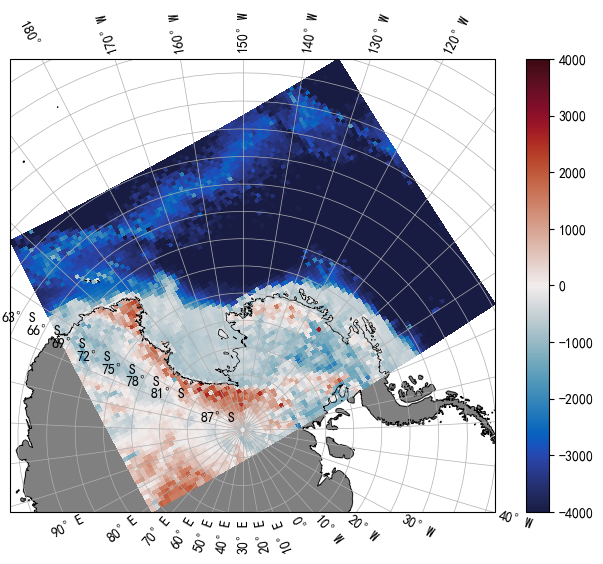

In [6]:
%matplotlib inline
plt.matplotlib.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize=[8, 6], subplot_kw={'projection': mproj})
ax.gridlines(xlocs=range(-180, 180, 10), ylocs=range(-90, 90, 3),
             linewidth=0.5, draw_labels=True)
ax.coastlines(resolution='10m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='gray')
pcm = ax.pcolormesh(xbpr_vert, ybpr_vert, bed, vmin=-4000, vmax=4000, cmap=cm.balance)
plt.colorbar(pcm, ax=ax)

### Mesh Generation with Boundary Interactor
At last, generate horizontal grid. Executing this block will generate a **NEW GUI** window out of jupyter notebook.

- To insert a new Node, point your mouse to the location and press **p/m/z** to insert new Node with beta value 1/-1/0.

- To delete a Node, point your mouse to the Node and press **d**.

- To move a Node around, mouse click and press on the Node, drag the node and release at a new location.

- To generate grid, press **G** (capital). Depending on the size of grid mesh, it may take a few minutes to generate grid.

- To exit BoundaryInteractor, close the window or press **N** (capital).

All key-binding commands:

        t : toggle visibility of verticies
        d : delete a vertex
        i : insert a vertex at a point on the polygon line
        u : set upper left corner

        p : set vertex as beta=1 (a Positive turn, marked with green triangle)
        m : set vertex as beta=-1 (a Negative turn, marked with red triangle)
        z : set vertex as beta=0 (no corner, marked with a black dot)

        G : generate grid from the current boundary using gridgen
        T : toggle visability of the current grid
        N : close plot and execute next step

In [6]:
%matplotlib qt
plt.matplotlib.rcParams['figure.dpi'] = 100
# Generate horizontal grid
data = np.loadtxt('nodes_info.txt')
xp, yp, beta = data[0], data[1], data[2]

# lonp1 = np.linspace(lon1, lon2, 2)[:-1]
# lonp2 = np.linspace(lon2, lon1, 11)[:-1]
# latp1 = np.linspace(lat1, lat2, 2)[:-1]
# latp2 = np.linspace(lat2, lat1, 2)[:-1]
# lonp = np.concatenate((lonp1, np.ones(len(latp1))*lon2,
#                        lonp2, np.ones(len(latp2))*lon1))
# latp = np.concatenate((np.ones(len(lonp1))*lat1, latp1,
#                        np.ones(len(lonp2))*lat2, latp2))
# beta = np.zeros(len(lonp))
# for i in range(len(beta)):
#     if (lonp[i] in [lon1, lon2]) and (latp[i] in [lat1, lat2]):
#         beta[i] = 1.

# xp, yp = pproj(lonp, latp)

# Plot map for bounary interactor
fig, ax = plt.subplots(subplot_kw={'projection': mproj})
ax.set_extent((xmin-dx, xmax+dx, ymin-dy, ymax+dy), crs=mproj)
ax.gridlines(xlocs=range(-180, 180, 10), ylocs=range(-90, 90, 3),
             linewidth=0.5, draw_labels=True)
ax.pcolormesh(xbpr_vert, ybpr_vert, -1*bed, cmap=cm.deep,
              vmin=200, vmax=4000, alpha=0.75)
ax.coastlines(resolution='10m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='gray')

# Activate boundary interactor
bry_itr = pyroms.hgrid.BoundaryInteractor(
    xp, yp, beta, shp=(Mm+1, Lm+1), proj=pproj)

Boundary Interactor Commands:

   t : toggle visibility of verticies
   d : delete a vertex
   i : insert a vertex at a point on the polygon line
   u : set upper left corner

   p : set vertex as beta=1 (a Positive turn, marked with green triangle)
   m : set vertex as beta=-1 (a Negative turn, marked with red triangle)
   z : set vertex as beta=0 (no corner, marked with a black dot)

   G : generate grid from the current boundary using gridgen
   T : toggle visability of the current grid
   N : close plot and execute next step

Deleting vertex
Inserting new vertex
Constructing C-Grid...
Grid construction complete.


Save information of nodes in a text file.

In [7]:
hgrid = bry_itr.grd
# Save nodes info to a txt file
np.savetxt('nodes_info.txt',
           np.vstack((hgrid.Gridgen.xbry,
                      hgrid.Gridgen.ybry,
                      hgrid.Gridgen.beta)),
           fmt='%30.15e')
print(hgrid)

### Refinement of Grid Mesh

Refine the grid mesh at certain location by specifying the coordinates, refinement intensity factor (>1), and normalized focus range (0<range<1).

Where to focus:

lonf = 190.

latf = -72.

Focus factor:

factorf = 5.

Focus range (normalized) in x/y direction:

rangefx = 0.5

rangefy = 0.75

The focus central location is not always accurate after focus is done. Need to adjust it constantly until it meets your requirements.

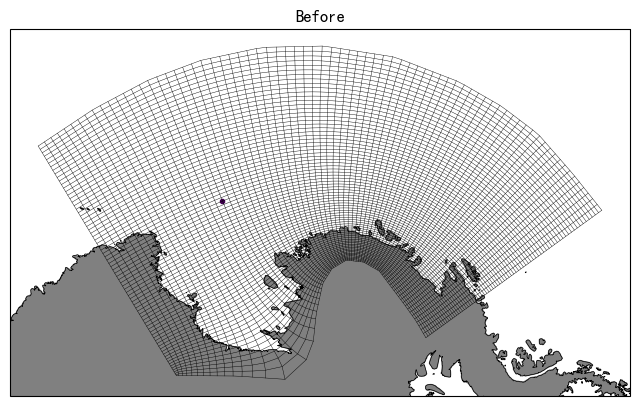

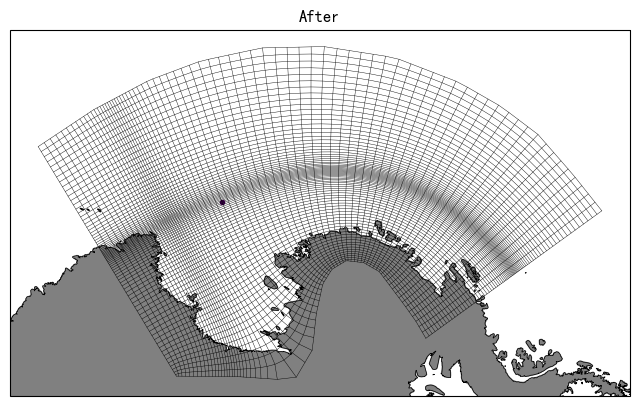

In [8]:
%matplotlib inline
plt.matplotlib.rcParams['figure.dpi'] = 100

xf, yf = pproj(lonf, latf)

# First, plot the original mesh
fig, ax = plt.subplots(figsize=[8, 6], subplot_kw={'projection': mproj})
ax.set_title('Before')
ax.coastlines(resolution='10m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='gray')
lines = ax.plot(hgrid.x_vert, hgrid.y_vert, '-k', lw=.3)
lines = ax.plot(hgrid.x_vert.T, hgrid.y_vert.T, '-k', lw=.3)
pt = ax.scatter(xf, yf, marker='.', c=10)

# Regenerate grid
hgrid.add_focus(lonf, latf, xfac=factorf, yfac=factorf, rx=rangefx, ry=rangefy)

# plot the new mesh
fig, ax = plt.subplots(figsize=[8, 6], subplot_kw={'projection': mproj})
ax.set_title('After')
ax.coastlines(resolution='10m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='gray')
lines = ax.plot(hgrid.x_vert, hgrid.y_vert, '-k', lw=.3)
lines = ax.plot(hgrid.x_vert.T, hgrid.y_vert.T, '-k', lw=.3)
pt = ax.scatter(xf, yf, marker='.', c=20)

### Make Land and Iceshelf Masks

pyROMS now has some built-in land/iceshelf masking utilities. These functions read coastline/iceshelf edge data as python shapely polygon objects, and check if each grid point is in one of the polygons.

By default, the coastline/iceshelf dataset used by pyROMS is the [Natural Earth](https://www.naturalearthdata.com/) free vector and raster map data, which is automatically fetched by the cartopy package. In general the utility accepts all datasets that describe coastlines as x/y coords. I did not create an input argument to pass in other data sources yet, but that could a feature in future revisions.

Note that land and iceshelf masks are often customized for each model configuration thus requires an external source of coastline. This is only an demonstration for the masking utilities.

Constructing land mask...
Total # of coast polygons:   55
processing:   55/  55
all coast polygons processed.


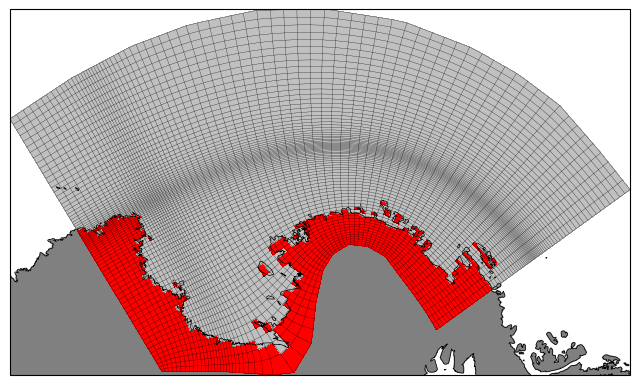

In [9]:
%matplotlib inline
plt.matplotlib.rcParams['figure.dpi'] = 100

hgrid.mask_land()

fig, ax = plt.subplots(figsize=[8, 6], subplot_kw={'projection': mproj})
ax.coastlines(resolution='10m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='gray')
ax.pcolormesh(hgrid.x_vert, hgrid.y_vert, hgrid.mask_rho, cmap=cmap)
lines = ax.plot(hgrid.x_vert, hgrid.y_vert, '-k', lw=.2)
lines = ax.plot(hgrid.x_vert.T, hgrid.y_vert.T, '-k', lw=.2)

Constructing iceshelf mask...
Total # of iceshelf polygons:   51
processing:   51/  51
all iceshelf polygons processed.


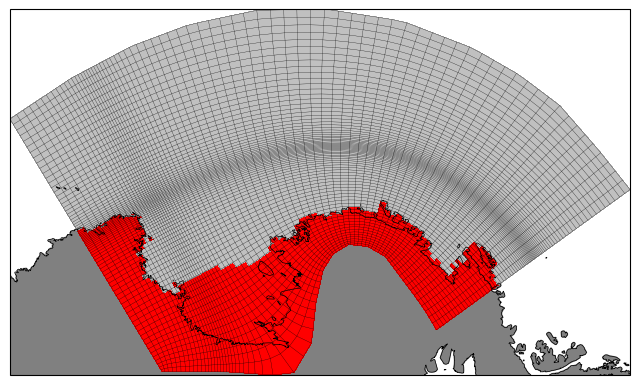

In [10]:
hgrid.mask_iceshelf()
# Make all land points to iceshelf points as well.
hgrid.mask_is[hgrid.mask_rho == 0] = 1

fig, ax = plt.subplots(figsize=[8, 6], subplot_kw={'projection': mproj})
ax.coastlines(resolution='10m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='gray')
ax.pcolormesh(hgrid.x_vert, hgrid.y_vert, 1-hgrid.mask_is, cmap=cmap)
lines = ax.plot(hgrid.x_vert, hgrid.y_vert, '-k', lw=.2)
lines = ax.plot(hgrid.x_vert.T, hgrid.y_vert.T, '-k', lw=.2)

### Manually Edit Masks
Edit land and iceshelf mask using an interactive editor. Just like the BoundaryInteractor, this block will launch a new GUI.

**left** mouse click: Change Land Mask

**right** mouse click: Change Iceshelf Mask

Key-binding commands:

        e : toggle between Editing/Viewing mode
        N : end mask editing mode

In [11]:
# import pyroms
# %matplotlib widget
# grd = pyroms.grid.get_ROMS_grid('ras_grd_raw.nc')
# hgrid = grd.hgrid
%matplotlib qt
mask_editor = pyroms.hgrid.EditMaskIJ(hgrid, iceshelf=True)
mask_editor()

Mask editing commands:
    left mouse click: Change Land Mask
    right mouse click: Change Iceshelf Mask
    e: Toggle between Editing/Viewing mode
    N: End mask editing mode
Change Mask:     i,   j, maskVal
Change Iceshelf Mask:    42    3      1
Change Mask:    42    3      0
End Change Mask
Change Mask:     i,   j, maskVal
Change Iceshelf Mask:    13   69      0
End Change Mask


## Temprary Save of Grid File

In [12]:
# Construct a simple vgrid for save files.
h = hmin*np.ones((Mm, Lm))
vgrid = pyroms.vgrid.SCoord(h, theta_b, theta_s, Tcline, N)
grd = pyroms.grid.ROMSGrid('Ross Amundsen', hgrid, vgrid)
grd.hgrid.longitude_wrap()
grd.write_grid('ras_grd_raw.nc')

Constructing Vertical Grid.
A. Shchepetkin (2010) UCLA-ROMS vertical coordinate transformation (Vtransform=2) and stretching (Vstretching=4) functions.
 ... wrote  theta_s
 ... wrote  theta_b
 ... wrote  Tcline
 ... wrote  hc
 ... wrote  s_rho
 ... wrote  s_w
 ... wrote  Cs_r
 ... wrote  Cs_w
 ... wrote  Vtransform
 ... wrote  Vstretching
 ... wrote  h
 ... wrote  zice
 ... wrote  hraw
 ... wrote  f
 ... wrote  pm
 ... wrote  pn
 ... wrote  dmde
 ... wrote  dndx
 ... wrote  xl
 ... wrote  el
 ... wrote  x_rho
 ... wrote  y_rho
 ... wrote  x_u
 ... wrote  y_u
 ... wrote  x_v
 ... wrote  y_v
 ... wrote  x_psi
 ... wrote  y_psi
 ... wrote  x_vert
 ... wrote  y_vert
 ... wrote  lon_rho
 ... wrote  lat_rho
 ... wrote  lon_psi
 ... wrote  lat_psi
 ... wrote  lon_vert
 ... wrote  lat_vert
 ... wrote  lon_u
 ... wrote  lat_u
 ... wrote  lon_v
 ... wrote  lat_v
 ... wrote  spherical
 ... wrote  angle
 ... wrote  mask_rho
 ... wrote  mask_u
 ... wrote  mask_v
 ... wrote  mask_psi
 ... wrote  mas

## Make Vertical Grid
Generation of vertical grid requires these steps:

- Interpolate raw bathymetry to new grid.
- Smooth bathymetry.

### Bathymetry interpolator
Use xarray and xesmf to regrid raw data to new grid.

xesmf is a very nice python interface for ESMF. It provides a few options for interpolation algorithm, and **bilinear** is used in this demo.

Technically **conservative** is a better option in terms of regridding of bathymetry, but it is computationally expensive , more suitable for working on a cluster or work station.

In [13]:
dsi = xr.open_dataset(bathy_file)
dso = xr.open_dataset('ras_grd_raw.nc')
grd = pyroms.grid.get_ROMS_grid('ras_grd_raw.nc')
hgrid = grd.hgrid

# Subsample
dsi = dsi.isel(x=slice(None, None, 10),y=slice(None, None, 10))

# Rename variables for xesmf convension.
dsi = dsi[['mask', 'surface', 'thickness', 'bed']]
dso = dso[['lon_rho', 'lat_rho']]
dso = dso.rename({'lon_rho': 'lon', 'lat_rho': 'lat'})

# Cut out the required BedMachine data piece and convert ESPG3031 coords
# to lat/lon coords. Note we need conor coords for conservative regridding.
x, y = bproj(dso.lon.data, dso.lat.data)
dx, dy = x.max() - x.min(), y.max() - y.min()
xmin, xmax = x.min() - 0.01*dx, x.max() + 0.01*dx
ymin, ymax = y.min() - 0.01*dy, y.max() + 0.01*dy
dsi = dsi.where(
    (dsi.x > xmin) & (dsi.x < xmax) & (dsi.y > ymin) & (dsi.y < ymax),
    drop=True)
x, y = dsi.x.data, dsi.y.data

x, y = np.meshgrid(x, y)
lon, lat = bproj(x, y, inverse=True)

dsi.coords['lon'] = (['y', 'x'], lon)
dsi.coords['lat'] = (['y', 'x'], lat)
# dsi = dsi.drop_vars(['x', 'y'])

dsi['lon'] = dsi.lon % 360

Load geographical grid from file
Constructing Vertical Grid.
A. Shchepetkin (2010) UCLA-ROMS vertical coordinate transformation (Vtransform=2) and stretching (Vstretching=4) functions.


In [14]:
# Convert BedMachine type masks to ROMS masks.
mask = dsi.mask.data
dsi = dsi.drop_vars('mask')
mask_rho = np.zeros(mask.shape)
mask_rho[(mask == 0) | (mask == 3)] = 1
mask_iceshelf = np.zeros(mask.shape)
mask_iceshelf[(mask == 1) | (mask == 2) | (mask == 3)] = 1

dsi['mask_rho'] = (('y', 'x'), mask_rho)
dsi['mask_iceshelf'] = (('y', 'x'), mask_iceshelf)

Plot the raw bathymetry data domain and grid mesh.

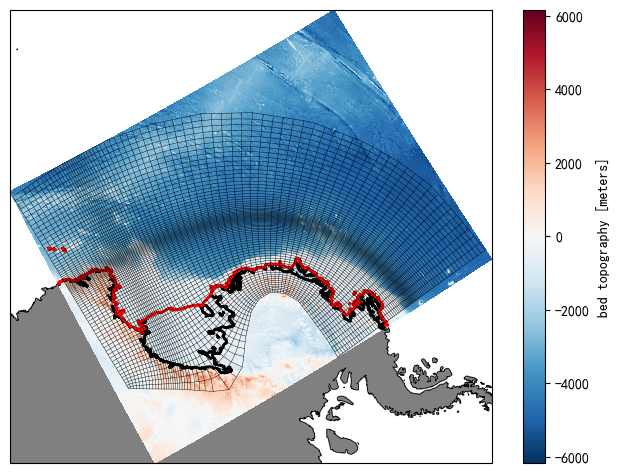

In [15]:
%matplotlib inline
plt.matplotlib.rcParams['figure.dpi'] = 100

xr, yr = pproj(dsi['lon'].data, dsi['lat'].data)
dsi.coords['x_rho'] = (('y', 'x'), xr)
dsi.coords['y_rho'] = (('y', 'x'), yr)

fig, ax = plt.subplots(figsize=[8, 6], subplot_kw={'projection': mproj})
ax.coastlines(resolution='10m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='gray')
dsi.bed.plot.pcolormesh(x='x_rho', y='y_rho', ax=ax)
dsi.mask_rho.plot.contour(x='x_rho', y='y_rho', colors='k', ax=ax)
dsi.mask_iceshelf.plot.contour(x='x_rho', y='y_rho', colors='r', ax=ax)
lines = ax.plot(hgrid.x_vert, hgrid.y_vert, 'k', lw=0.3)
lines = ax.plot(hgrid.x_vert.T, hgrid.y_vert.T, 'k', lw=0.3)

### Raw bathymetry smoothing

Use a Gaussian filter to smooth the raw bathymetry. Gaussian filter is often used to blur images. Since BedMachine is evenly spaced in both direction, an image filter would work fine.

Filtering of raw bathymetry is an optional step; it is meant to prevent interpolating over abnormal values when **bilinear** interpolator is used. When **conservative** interpolation is used, raw bathymetry smoothing is not required.

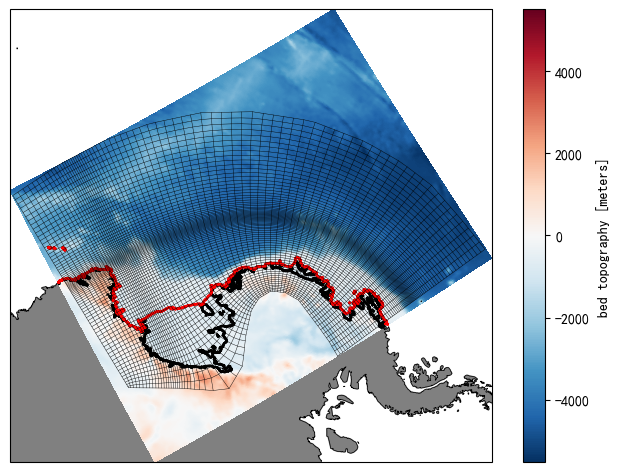

In [16]:
# Use Gaussian filter to pre-process the raw bathymetry
sigma = 3.0
zero_filt = gaussian_filter(dsi.mask_iceshelf, sigma)
dsi['bed'].values = gaussian_filter(dsi.bed, sigma)
dsi['surface'].values = gaussian_filter(dsi.surface, sigma)/zero_filt
dsi['thickness'].values = gaussian_filter(dsi.thickness, sigma)/zero_filt

fig, ax = plt.subplots(figsize=[8, 6], subplot_kw={'projection': mproj})
ax.coastlines(resolution='10m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='gray')
dsi.bed.plot.pcolormesh(x='x_rho', y='y_rho', ax=ax)
dsi.mask_rho.plot.contour(x='x_rho', y='y_rho', colors='k', ax=ax)
dsi.mask_iceshelf.plot.contour(x='x_rho', y='y_rho', colors='r', ax=ax)
lines = ax.plot(hgrid.x_vert, hgrid.y_vert, 'k', lw=0.3)
lines = ax.plot(hgrid.x_vert.T, hgrid.y_vert.T, 'k', lw=0.3)

### Regridding

Use xesmf to perform regridding over bed bathymetry, ice shelf thickness and surface elevation.

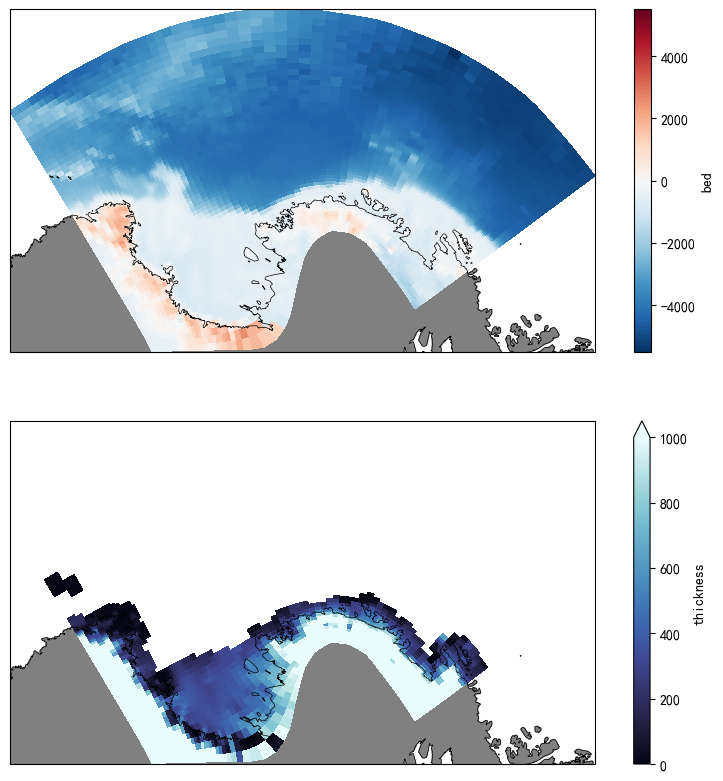

In [17]:
# Build and apply xesmf regridder.
regridder = xe.Regridder(dsi, dso, 'bilinear')
dsr = regridder(dsi)

# Since conservative remapping gives float values for masks, convert them
# to integer values.
dsr['mask_rho'] = dsr.mask_rho.where(dsr.mask_rho > 0.9, 0)
dsr['mask_rho'] = dsr.mask_rho.where(dsr.mask_rho == 0, 1)
dsr['mask_iceshelf'] = dsr.mask_iceshelf.where(dsr.mask_iceshelf > 0.9, 0)
dsr['mask_iceshelf'] = dsr.mask_iceshelf.where(dsr.mask_iceshelf == 0, 1)

# Rename coordinates to follow ROMS convension.
ds = dsr.rename({'lon': 'lon_rho', 'lat': 'lat_rho'})
xr, yr = pproj(ds.lon_rho.data, ds.lat_rho.data)
ds.coords['x_rho'] = (('eta_rho', 'xi_rho'), xr)
ds.coords['y_rho'] = (('eta_rho', 'xi_rho'), yr)

fig, ax = plt.subplots(2, 1, figsize=[10, 10], subplot_kw={'projection': mproj})
ax[0].coastlines(resolution='10m', linewidth=0.5)
ax[0].add_feature(cfeature.LAND, facecolor='gray')
ax[1].coastlines(resolution='10m', linewidth=0.5)
ax[1].add_feature(cfeature.LAND, facecolor='gray')
ds.bed.plot.pcolormesh(x='x_rho', y='y_rho', ax=ax[0])
ds.thickness.plot.pcolormesh(x='x_rho', y='y_rho', ax=ax[1], vmin=0, vmax=1000, cmap=cm.ice)

Convert bed bathymetry, ice shelf thickness and surface elevation to **h** and **zice** in ROMS.

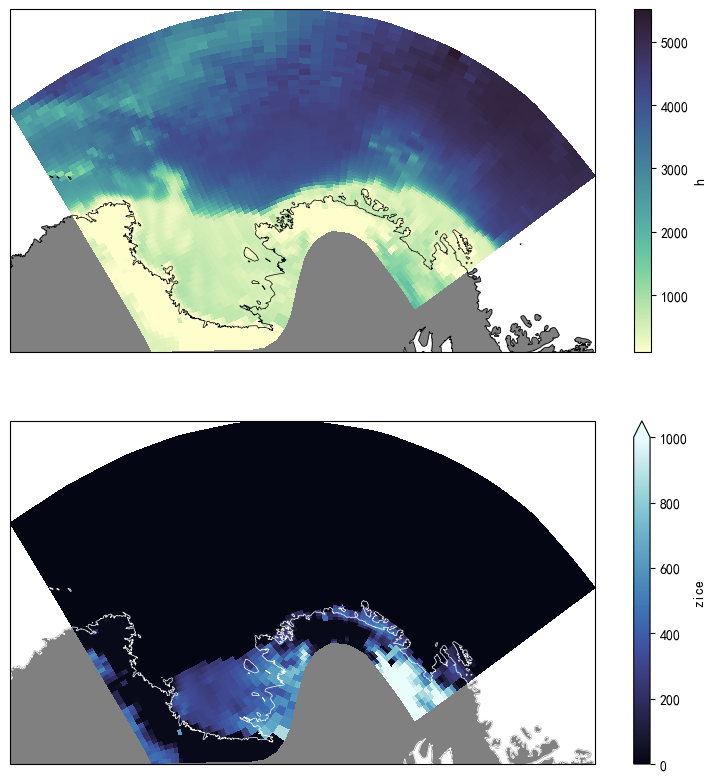

In [18]:
ds['hraw'] = -ds.bed
ds['h'] = -ds.bed
ds['ziceraw'] = ds.thickness - ds.surface
ds['zice'] = ds.thickness - ds.surface
ds.mask_rho.values = hgrid.mask_rho
ds.mask_iceshelf.values = hgrid.mask_is

# Reset minimum water column/zice thickness
ds['zice'] = ds.zice.where(ds.zice > zicemin, zicemin)
ds['zice'] = ds.zice.where(ds.mask_iceshelf == 1, 0)
ds['h'] = ds.h.where(ds.h > hmin, hmin)

fig, ax = plt.subplots(2, 1, figsize=[10, 10], subplot_kw={'projection': mproj})
ax[0].coastlines(resolution='10m', linewidth=0.5)
ax[0].add_feature(cfeature.LAND, facecolor='gray')
ax[1].coastlines(resolution='10m', linewidth=0.5, color='w')
ax[1].add_feature(cfeature.LAND, facecolor='gray')
ds.h.plot.pcolormesh(x='x_rho', y='y_rho', ax=ax[0], cmap=cm.deep)
ds.zice.plot.pcolormesh(x='x_rho', y='y_rho', ax=ax[1], vmin=0, vmax=1000, cmap=cm.ice)

### Bathymetry Smoothing with Linear Programming Algorithm

In the old version of pyROMS, the Linear Programming smoothing code is almost directly translated from the MATLAB ROMS utilities. The code is optimized for Python thus is not very efficient, plus it requires the user to install lpsolve55 externally and configure it correctly, which may cause troubles for beginners.

It turns out the Python package **scipy** already has linear programming integrated. It provides a nice python interface that can be much more easily implemented. I've rewritten the LP_smoothing code in pyROMS, and here is the demo.

Max Roughness value is:  <xarray.DataArray ()>
array(0.75829273)
eta_rho =  75   xi_rho =  75
ListCoord built
Computing inequalities for rx0 =  0.4
Inequalities for dh(iEta,iXi) and dh(iEta+1,iXi)
Inequalities for dh(iEta,iXi) and dh(iEta,iXi+1)
Inequalities dh <= ad and -dh <= ad
eta_rho =  75   xi_rho =  75
Inequalities |h^{new} - h^{old}| <= alpha h^{old}
eta_rho =  75   xi_rho =  75
Inequalities dh >= 0 or dh <= 0
Solver Matrix Size, 272505, 92445
rx0max =  0.4   MaxRx0 =  0.4000000059604645
Max Roughness value is:  <xarray.DataArray ()>
array(0.40000001)


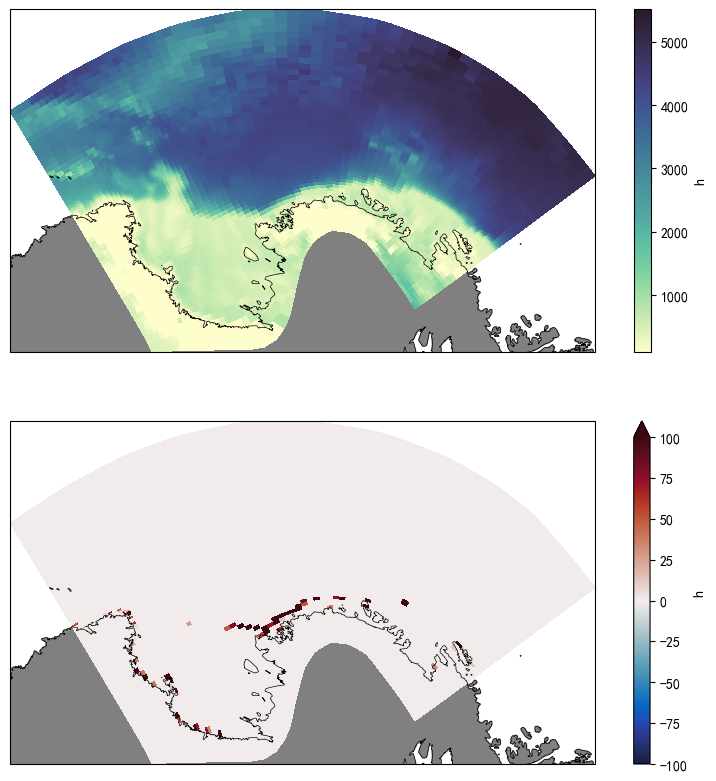

In [19]:
# Smooth bathymetry
rx0max = 0.4
rx = pyroms.bathy_tools.roughness0(ds.h, ds.mask_rho)
print('Max Roughness value is: ', rx.max())

hraw = ds.h.data

if rx.max() > rx0max:
    ds['h'] = pyroms.bathy_tools.lp_smoothing.LP_smoothing_rx0(
        ds.mask_rho, ds.h, rx0max, 0, 1e5)

# Reset minimum water column/zice thickness
ds['hw'] = ds.h - ds.zice
ds['hw'] = ds.hw.where(ds.hw > hwmin, hwmin)
ds['zice'] = ds.h - ds.hw
ds['zice'] = ds.zice.where(ds.zice > zicemin, zicemin)
ds['zice'] = ds.zice.where(ds.mask_iceshelf == 1, 0)
ds['h'] = ds.zice + ds.hw
ds['h'] = ds.h.where(ds.h > hmin, hmin)

rx = pyroms.bathy_tools.roughness0(ds.h, ds.mask_rho)
print('Max Roughness value is: ', rx.max())

fig, ax = plt.subplots(2, 1, figsize=[10, 10], subplot_kw={'projection': mproj})
ax[0].coastlines(resolution='10m', linewidth=0.5)
ax[0].add_feature(cfeature.LAND, facecolor='gray')
ax[1].coastlines(resolution='10m', linewidth=0.5)
ax[1].add_feature(cfeature.LAND, facecolor='gray')
ds.h.plot(x='x_rho', y='y_rho', ax=ax[0], cmap=cm.deep)
(ds.h - hraw).plot(x='x_rho', y='y_rho', ax=ax[1], vmin=-100, vmax=100, cmap=cm.balance)

In [20]:
# Construct vertical grid
vgrid = pyroms.vgrid.SCoord(ds.h.values, theta_b, theta_s, Tcline, N,
                            zice=ds.zice.values,
                            hraw=ds.hraw.values)
vgrid.ziceraw = ds.ziceraw.values
grd = pyroms.grid.ROMSGrid('Ross Amundsen Sea', hgrid, vgrid)

# Write grid
grd.write_grid('../data/ras_grd.nc')

Constructing Vertical Grid.
A. Shchepetkin (2010) UCLA-ROMS vertical coordinate transformation (Vtransform=2) and stretching (Vstretching=4) functions.
 ... wrote  theta_s
 ... wrote  theta_b
 ... wrote  Tcline
 ... wrote  hc
 ... wrote  s_rho
 ... wrote  s_w
 ... wrote  Cs_r
 ... wrote  Cs_w
 ... wrote  Vtransform
 ... wrote  Vstretching
 ... wrote  h
 ... wrote  zice
 ... wrote  ziceraw
 ... wrote  hraw
 ... wrote  f
 ... wrote  pm
 ... wrote  pn
 ... wrote  dmde
 ... wrote  dndx
 ... wrote  xl
 ... wrote  el
 ... wrote  x_rho
 ... wrote  y_rho
 ... wrote  x_u
 ... wrote  y_u
 ... wrote  x_v
 ... wrote  y_v
 ... wrote  x_psi
 ... wrote  y_psi
 ... wrote  x_vert
 ... wrote  y_vert
 ... wrote  lon_rho
 ... wrote  lat_rho
 ... wrote  lon_psi
 ... wrote  lat_psi
 ... wrote  lon_vert
 ... wrote  lat_vert
 ... wrote  lon_u
 ... wrote  lat_u
 ... wrote  lon_v
 ... wrote  lat_v
 ... wrote  spherical
 ... wrote  angle
 ... wrote  mask_rho
 ... wrote  mask_u
 ... wrote  mask_v
 ... wrote  mask